# Assignment 5 - Boosting

### <span style="color:red">THIS IS HOMEWORK.</span>
### Due: May 15th, 11:59 pm on Canvas.
> **Copyright ©2019 University of Washington**  

> **Emily Fox**, author of the TuriCreate based version of this assignment.  
> **Sewoong Oh**, instructor of CSE/STAT 416 for Spring 2019.  
> **Joshua Fan**, generously offered a LOT help in debugging and testing.
> **Anna Neufeld**, generously offered a lot of help in code review. 
> **Hongjun Wu**, revisor of the Scikit-Learn based version of this assignment.  
> **Henry Wong**, wrote the pre-processing code for categorical encoding.    
> **All rights reserved.**

### Clarification
* <span style="color:red">Read & post to this [Assignment 5 Clarifications](https://canvas.uw.edu/courses/1271722/discussion_topics/4817620) if you are not sure of something.</span>

### Purpose
* We will explore the use of boosting. 
* We will play with the pre-implemented gradient boosted trees. 
 
### Method & Summary
* Use Scikit-Learn to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

### Permission
* Permission is hereby granted to students registered for University of Washington CSE/STAT 416.
* For use solely during Spring Quarter 2019 for purposes of the course.  
* No other use, copying, distribution, or modification is permitted without prior written consent. 
* Copyrights for third-party components of this work must be honored.  
* Instructors interested in reusing these course materials should contact the author.

> If you have any questions or you are unclear what we are refering to in this homework, please do not hesitate to reach out! Post a discussion and we would love to listen to and answer your questions. Hope you enjoy this assignment 😜 (Well I enjoyed writing it since ya don't get the chance to write emoji into CSE assignment prompt at 4AM very often)

## Import Packages

In [1]:
# Import Statement
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Magic Function (Like...magic)
# Interested? Don't know what it means? Read this!
# https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
%matplotlib inline

# Make Pandas print more stuff
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

> Again, stuff wrote in blockquotes is optional. Just something we think is useful to have around.

## Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. 
* The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors.

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

In the decision trees assignment, we walked through several steps of data preparation, for example:
- converting the target column to [-1, +1]
- selecting a subset of the features that we think will be important
- skipping observations with missing values
- sampling to balance the target classes

To save time in this assignment, we have done these steps in advance, and saved the `DataFrame` in a new file called `clean-lending-club-data.csv`, which we can load in and immediately work with. If you are interested in these data preparation steps, please refer back to A4.

### Load Data Basics
* First, we will load in all the club data from file using `pd.read_csv()`. 

> If you need the dataset:   
Download it in Canvas under [/files/Assignment Resources/data/](https://canvas.uw.edu/courses/1271722/files/folder/Assignment%20Resources/data).  

> If data failed to load:   
[1] Check if you have the correct file and is in the correct location!   
[2] Make sure you have `clean-lending-club-data.csv`, not `clean-lending-club-data.gl`!

> Reminders:  
`'./'` means that you are finding a file within the same directory as the notebook.   
`'../'` means that you are looking for a file or folder one hierarchy above.

In [5]:
loans_data = pd.read_csv('/data/clean-lending-club-data.csv')

Let's quickly explore what the dataset looks like.   
First, let's print out the data and take a look at the column names to see what features we have in this dataset.   
We talked about it since Assignment 2, so we won't belabor this here.

In [6]:
loans_data[0:5]

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
0,-1,C,0.8,1,1,RENT,1.00,car,2.39320,0,1,5,1,1,3,0,1,9.4,0.0,15.27,435.17,30000,2500,2500,59.83
1,-1,F,0.4,0,5,OWN,5.55,small_business,4.57170,0,1,2,1,1,11,0,1,32.6,0.0,21.28,294.94,40000,5600,5600,152.39
2,-1,B,1.0,1,1,RENT,18.08,other,9.71600,0,1,0,1,1,2,0,1,36.5,0.0,12.69,533.42,15000,5375,5350,121.45
3,-1,C,0.2,1,1,RENT,10.08,debt_consolidation,12.21520,0,1,1,1,1,4,0,1,91.7,0.0,13.49,570.26,30000,9000,9000,305.38
4,-1,B,0.4,0,4,RENT,7.06,other,3.90888,0,1,2,1,1,14,0,1,55.5,0.0,10.65,1393.42,100000,10000,10000,325.74


### Define features and target
> * The steps we did here to process data seems redundant...why don't we just call `pd.get_dummies(loans_data)`?
    * You are right! Since we are moving to one-hot encoding categorical features, it is unnecessary to define the features first hand.
    * However, the original version of this assignment had a detailed explaination of what each feature means.
    * So if you are interested, you can see what all the features means below.

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

# Extract the feature columns and target column
loans_data = loans_data[features + [target]]

loans_data[0:5]

,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,safe_loans
0,C,0.8,1,1,RENT,1.00,car,2.39320,0,1,5,1,1,3,0,1,9.4,0.0,15.27,435.17,30000,2500,2500,59.83,-1
1,F,0.4,0,5,OWN,5.55,small_business,4.57170,0,1,2,1,1,11,0,1,32.6,0.0,21.28,294.94,40000,5600,5600,152.39,-1
2,B,1.0,1,1,RENT,18.08,other,9.71600,0,1,0,1,1,2,0,1,36.5,0.0,12.69,533.42,15000,5375,5350,121.45,-1
3,C,0.2,1,1,RENT,10.08,debt_consolidation,12.21520,0,1,1,1,1,4,0,1,91.7,0.0,13.49,570.26,30000,9000,9000,305.38,-1
4,B,0.4,0,4,RENT,7.06,other,3.90888,0,1,2,1,1,14,0,1,55.5,0.0,10.65,1393.42,100000,10000,10000,325.74,-1


### Some Pre-processing on Categorical Features (You saw it in the last assignment)
#### cr. Henry Wong
* Due to a quirk in Sklearn's Decision Tree implementation, Scikit-Learn is only able to accept categorical features. 
* Therefore we will encode the categorical features in our dataset with onehot encoding using pandas' `get_dummies()` function. 
* Thus we will also need to modify our features list accordingly.

In [8]:
loans_data = pd.get_dummies(loans_data)
loans_data[0:5]

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
0,0.8,1,1,1.00,2.39320,0,1,5,1,1,3,0,1,9.4,0.0,15.27,435.17,30000,2500,2500,59.83,-1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0.4,0,5,5.55,4.57170,0,1,2,1,1,11,0,1,32.6,0.0,21.28,294.94,40000,5600,5600,152.39,-1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,1,18.08,9.71600,0,1,0,1,1,2,0,1,36.5,0.0,12.69,533.42,15000,5375,5350,121.45,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.2,1,1,10.08,12.21520,0,1,1,1,1,4,0,1,91.7,0.0,13.49,570.26,30000,9000,9000,305.38,-1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0.4,0,4,7.06,3.90888,0,1,2,1,1,14,0,1,55.5,0.0,10.65,1393.42,100000,10000,10000,325.74,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [9]:
features = list(loans_data.columns)
features.remove(target)
features

['sub_grade_num',
 'short_emp',
 'emp_length_num',
 'dti',
 'payment_inc_ratio',
 'delinq_2yrs',
 'delinq_2yrs_zero',
 'inq_last_6mths',
 'last_delinq_none',
 'last_major_derog_none',
 'open_acc',
 'pub_rec',
 'pub_rec_zero',
 'revol_util',
 'total_rec_late_fee',
 'int_rate',
 'total_rec_int',
 'annual_inc',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

What remains now is a subset of features and the target that we will use for the rest of this notebook.

## Split data into training and validation sets

* Hey, you look nice today 😆    
    * Seriously, if you aren't doing this super last minute...the weather is great outside!
* We split the data into training data and validation data. 
* Let's use `random_state=1` to make sure everyone gets the same results! 
* We will use the validation data to help us select model parameters.

In [10]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(loans_data, test_size=0.2, random_state=1)

* Let's take a look at how many data in each set!

In [11]:
print(train_data.shape)
print(validation_data.shape)

(37202, 45)
(9301, 45)


#### What does this mean?
* You should have 37202 data in the training set, and 9301 data in the test set.
* Each with 45 columns, each column is a feature.

# Adaboosted tree classifier

Adaboosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

>**Resources:** If you are interested in adaboosted trees, here is some useful additional reading material:
* [Doc: sk.ensemble.AdaBoostClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)
* [Optional Reading: Advanced Material on Boosted Trees Slide](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)
* [Demo: Two Class Adaboost](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html)
* [Demo: Feature Transformation with Ensembles of Trees (For advanced humans)](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py)


* We will now train models to predict `safe_loans` using the features above.

### Making the model
* Train an AdaBoostClassifier model with 5 DecisionTreeClassifiers, each with depth 7. Save the model to `model_5`.

* Use `train_data` to fit the model. `features` contains the list of input features, and `target` is what we are trying to predict.

* Set `random_state=1` when constructing both the DecisionTreeClassifier and AdaBoostClassifier, so that we get the same results

* More details:
    * Remember when we talked in last homework, the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) uses the `max_depth` parameter to control the depth of the tree?
    * AdaBoostClassifier is essentially using many trees, so when you call AdaBoostClassifier, it is actually calling `DecisionTreeClassifier(max_depth=someNumberOfDepth)` from the inside to create a AdaBoostClassifier model. We use a parameter called `n_estimators` to determine how many trees to use when constructing the AdaBoostClassifier.
    * Note: Because we are using a small number of trees, we need to make the trees a bit deeper to achieve optimum result. Namely, instead of each tree has depth of `5`, we let it to have depth`7` to make it a bit better.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [36]:
## Write your code here!
model_5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 7, random_state=1), n_estimators = 5, random_state = 1)
model_5.fit(train_data[features], train_data[target])


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
          learning_rate=1.0, n_estimators=5, random_state=1)

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: Use the `accuracy_score` that we used in the last assignment.

In [37]:
# Import Statement
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [38]:
## Write your code here!
accuracy_score(validation_data[target], model_5.predict(validation_data[features]))

0.6628319535533813

Calculate the number of **false positives** made by the model on the validation set.

If you are trying to loop through the true target values index by index, note that `validation_data[target]` is a **data frame**. So to access the i-th row, you'll need to do `validation_data[target].iloc[i]`. 

In [41]:
## Write your code here!

fp = 0
pred = model_5.predict(validation_data[features])
true = validation_data[target]
for i in range(len(true)):
    if pred[i] == 1 and true.iloc[i] == -1:
        fp += 1
print(fp)

1636


### **Q1**: What is the number of **false positives** on the **validation_data**? 1636

Calculate the number of **false negatives** made by the model on the validation set.

In [40]:
## Write your code here!
fn = 0
for i in range(len(true)):
    if pred[i] == -1 and true.iloc[i] == 1:
        fn += 1
print(fn)

1500


### **Q2**: What is the number of **false negatives** on the **validation_data**? 1500

## Comparison with decision trees
* Let's see what if we just use a simple decision tree instead.
    * Using a simple decision tree, the validation accuracy is: 0.6569186109020535.
    * Since calculating this would be repeated work, we calculated it for you.

Here, we quantify the benefit of the extra increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1552
* **False positives**: 1639

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1552  + $20,000 * 1639 = $48300000
```

The total cost of the mistakes of the model is $48.3M. That is a **lot of money**!.

### **Q3**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**? 47720000

In [42]:
## Write your code here!
10000*fn + 20000*fp

47720000

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.🤑

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. 
#### Hint:
* There is a method in the [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) that can predict class probabilities of a certain input.
* That method returns a probability of +1 and a probability of -1, make sure you are using the right one.(!!!)
* Note: the method will return a 2-D list. Each sub-list contains two entries; first is the probability of -1, and second is the probability of +1. To extract the second column (with the probabilities of +1), you can do `[:,1]` to the end of the 2-D list.
* [How to extract a column from a n-D array?](https://stackoverflow.com/questions/903853/how-do-you-extract-a-column-from-a-multi-dimensional-array)

In [47]:
# Write your code here!
predictions = model_5.predict_proba(validation_data[features])
validation_data['predictions'] = predictions[:,1]

**Checkpoint:** For each row, the probabilities should be a number in the range **[0, 1]**. We have provided a simple check here to make sure your answers are correct.

In [48]:
print("Your loans      : %s\n" % list(validation_data['predictions'].head(4)))
print("Expected answer : %s" % [0.5572405466863586, 0.5134051586799435,
                                0.47499886376920475, 0.5645160637619324])

Your loans      : [0.5572405466863586, 0.5134051586799435, 0.47499886376920475, 0.5645160637619324]

Expected answer : [0.5572405466863586, 0.5134051586799435, 0.47499886376920475, 0.5645160637619324]


Now, we are ready to go to **Step 3**. You can now use the `predictions` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [52]:
# Write your code here!
validation_data.nlargest(5, 'predictions')

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,predictions
39608,0.2,0,4,0.16,0.961132,0,1,0,1,1,5,0,1,11.9,0.00,6.03,1035.11,456000,12000,12000,365.23,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1.000000
15648,0.2,0,4,7.77,3.652300,0,1,0,1,1,6,0,1,6.1,18.26,6.03,905.49,120000,12000,12000,365.23,-1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1.000000
39687,0.2,0,10,4.80,1.542080,0,1,0,1,1,9,0,1,4.5,0.00,6.03,94.62,225000,9500,9500,289.14,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.999963
26559,0.2,0,3,5.14,1.723430,0,1,1,1,1,7,0,1,8.5,0.00,5.42,428.41,105000,5000,5000,150.80,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.999575
45831,0.2,1,1,6.69,3.371350,0,1,1,1,1,8,0,1,5.2,0.00,6.03,634.56,130000,12000,12000,365.23,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.999574


### **Q4**: What grades are the top 5 loans?

Hint: remember that the `grade` feature was one-hot encoded. For example, the `grade_A` column is 1 if the loan was grade A, and 0 otherwise.
- ABACB
- BBBAA
- BACAA
- AAAAA (o)
- BBCBA

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [53]:
# Write your code here!
validation_data.nsmallest(5, 'predictions')

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,predictions
1636,0.2,0,5,1.49,2.99743,3,0,0,0,1,5,0,1,13.4,0.0,15.62,0.0,42000,3000,3000,104.91,-1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.067802e-09
4901,1.0,0,2,4.45,13.45090,0,1,2,0,1,13,0,1,2.5,0.0,13.79,0.0,76000,25000,11625,851.89,-1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5.342747e-09
5608,1.0,0,2,3.62,3.95203,0,1,5,1,1,4,0,1,83.9,0.0,14.26,0.0,250000,24000,23075,823.34,-1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,5.502721e-09
3142,0.6,0,2,2.94,4.82151,0,1,3,1,1,4,0,1,38.1,0.0,9.62,0.0,19968,2500,2500,80.23,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,6.678670e-09
20988,1.0,0,9,4.42,8.43097,1,0,0,0,1,8,0,1,44.4,0.0,14.99,0.0,148000,30000,30000,1039.82,-1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.096260e-08


**Q5:** What grades are the bottom 5 loans?
- FCBFE
- DCCBC (o)
- FFCED
- DDBDD
- FCFFF

## Effect of adding more trees

In this assignment, we will train several different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 15, 20, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

* Fill in the code below to populate the `models` list with models using the given numbers of trees.
    * In this models, we will let the depth of each tree to be `3` instead of `7` in the previous section, so we can observe the effect of adding many many many small trees.
    * Again, set `random_state=1` every time you create an AdaBoostClassifier and DecisionTreeClassifier.
* **Warning:** This could take a while to run, so don't panic! We are training a model with 500 trees.
    * I got a pretty little status bar for you! So you don't need to write ugly print statements!
    * [How to display a progress bar in notebook?](https://mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook-47bd4c2944bf)

In [54]:
# Status Bar
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


In [58]:
## Write your code here!
models = []
tree_counts = [10,15,20,50,100,200,500]
progress = 0
all_iterations = sum(tree_counts)


for x in tree_counts:
    print('Currently training model tree size:',x)  # Progress Bar
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, random_state=1), n_estimators = x, random_state = 1)
    model.fit(train_data[features], train_data[target])
    models.append(model)

    progress += x  # Progress Bar
    update_progress(progress / all_iterations)  # Progress Bar
    
update_progress(1)  # Progress Bar

Progress: [####################] 100.0%


## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 15, 20, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `accuracy_score` method.

In [74]:
## Write your code here!
accs = list()
for m in models:
    acc = accuracy_score(validation_data[target], m.predict(validation_data[features]))
    accs.append(acc)
print(accs)

[0.6640146220836469, 0.6632620148371143, 0.665412321255779, 0.6716482098699065, 0.669605418772175, 0.6646597140092463, 0.6520804214600581]


**Q6:** Which model has the **best** accuracy on the **validation_data**?
- 10 tree
- 15 tree
- 50 tree (o)
- 100 tree
- 200 tree
- 500 tree

**Q7:** Is it always true that the model with the most trees will perform best on test data?
- yes
- no (o)

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 15, 20, 50, 100, 200, and 500 tree models. We will use [matplotlib](https://matplotlib.org/index.html) in order to visualize the plots. 

First, run the following method to use as graphing code.

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `accuracy_score()`. 

Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models with 10, 15, 20, 50, 100, 200, and 500 trees, and store these errors in a list `training_errors`.

Note that the classification error is just 1 minus the accuracy score.

In [82]:
## Write your code here!
training_errors = []
for m in models:
    err = 1-accuracy_score(train_data[target], m.predict(train_data[features]))
    training_errors.append(err)
print(len(training_errors))
print(len(tree_counts))

7
7


Now, onto **Step 2**. Write code to compute the classification error on the **validation_data** for models 10, 15, 20, 50, 100, 200, and 500 trees, saving this into a different list `validation_errors`.

In [83]:
## Write your code here!
validation_errors = []
for m in models:
    err = 1-accuracy_score(validation_data[target], m.predict(validation_data[features]))
    validation_errors.append(err)
print(len(validation_errors))

7


Now, we will plot the `training_errors` and `validation_errors` versus the number of trees. We will compare the 10, 15, 20, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

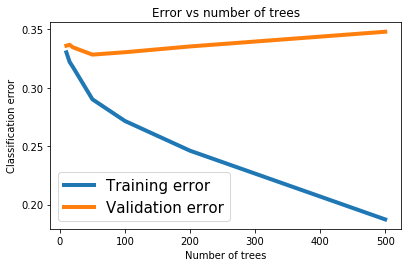

In [84]:
plt.plot(tree_counts, training_errors, linewidth=4.0, label='Training error')
plt.plot(tree_counts, validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Q8**: According to the graph, does the training error reduce as the number of trees increases?
- Yes (o)
- No
- Yes and No (Depends)

**Q9**: Is it always true that the validation error will reduce as the number of trees increases?
- Yes
- No (o)

### Well, it looks like you are really an intellegent boosted human to reach this point.
### Oh yeah, there is another notebook you need to do, just so you know.
* It's like Erwin Schrödinger's CSE 416 Homework 5.
    * When I am writing this assignment 4 AM in the morning, you are at a state that you both completed and did not complete all the assignment.
    * Now, you can observe yourself and make sure you are in a state that you completed all of Assignment 5. 
    * If not, there is a document retrieval part of Assignment 5 which you can learn all about studying a group of famous and powerful american humans!
    * (Nope, not the super heroes, sorry)
    
### Don't forget to make sure you submitted your quiz AND your notebook!  
### You might want to post to this [really cool online discussion board](https://canvas.uw.edu/courses/1271722/discussion_topics) too.|